In [1]:
import torch
from torchvision import models
import numpy as np

from utils import ResnetFeatureExtractor, make_comparison_plot_similarity

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
resnet = models.resnet50(pretrained=True).to(device)
resnet.eval()
model = ResnetFeatureExtractor(resnet)

/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/milte/anaconda3/envs/torch-cv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


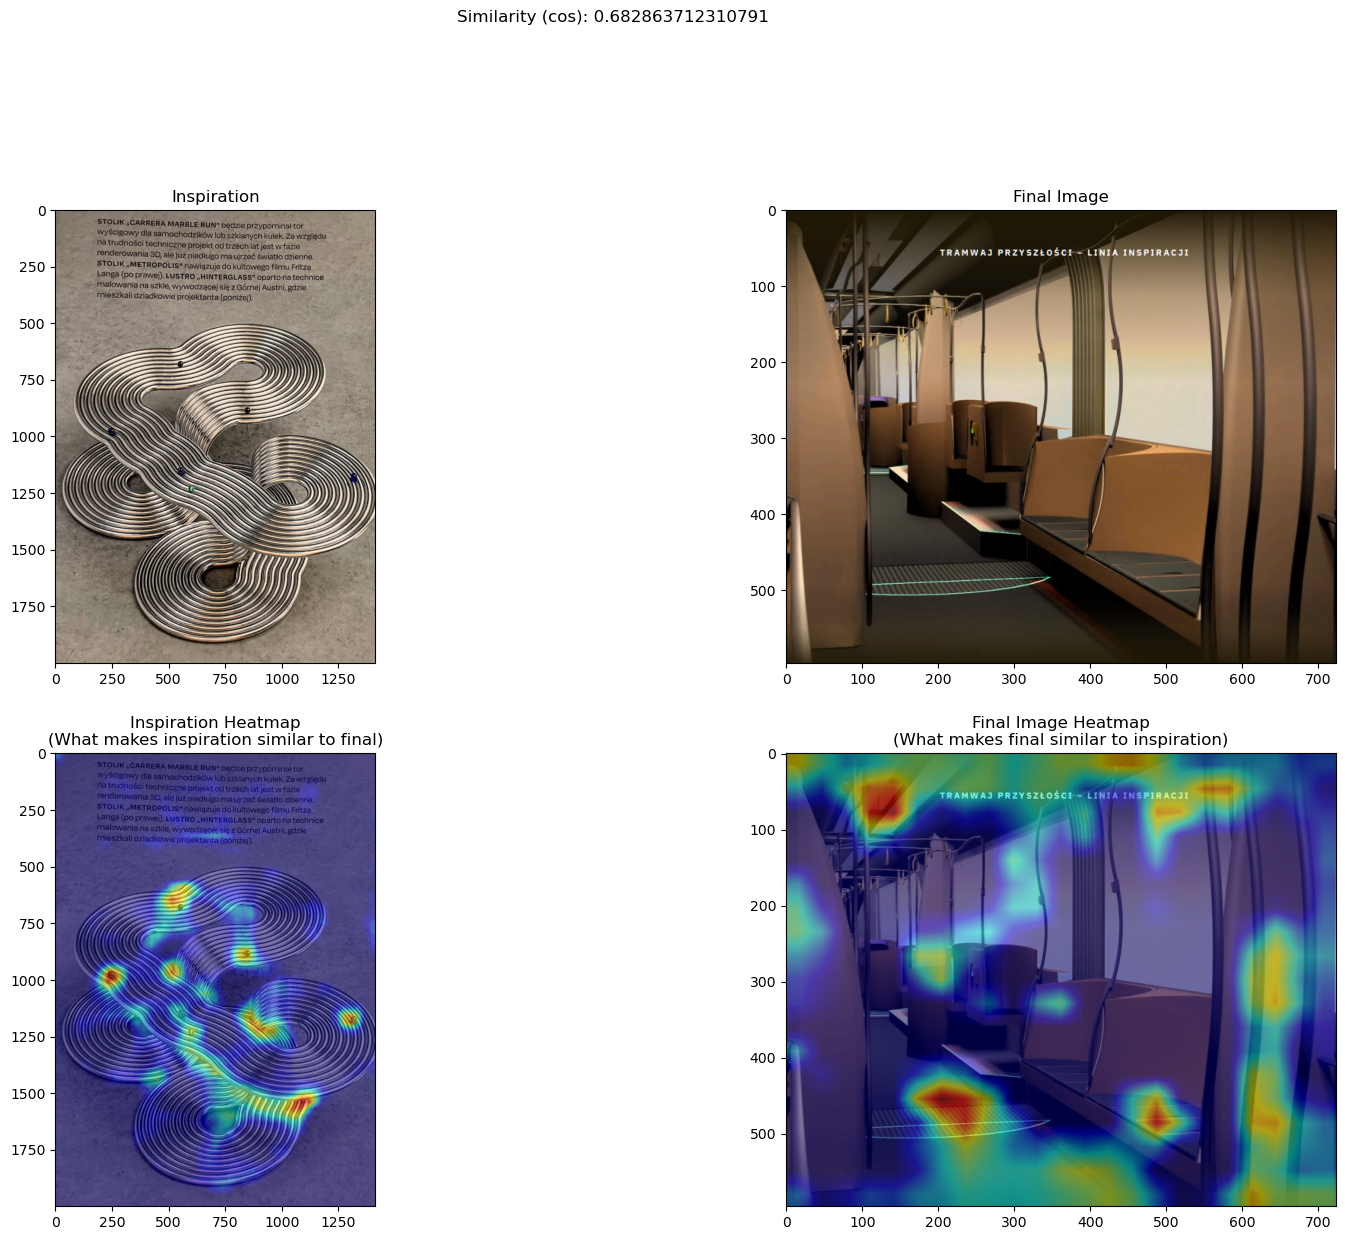

In [4]:
make_comparison_plot_similarity(
    "/home/milte/Desktop/ainspired/data/web/20B_2.png",
    "/home/milte/Desktop/ainspired/data/final_submissions/20/8.jpg",
    model,
    device
    )

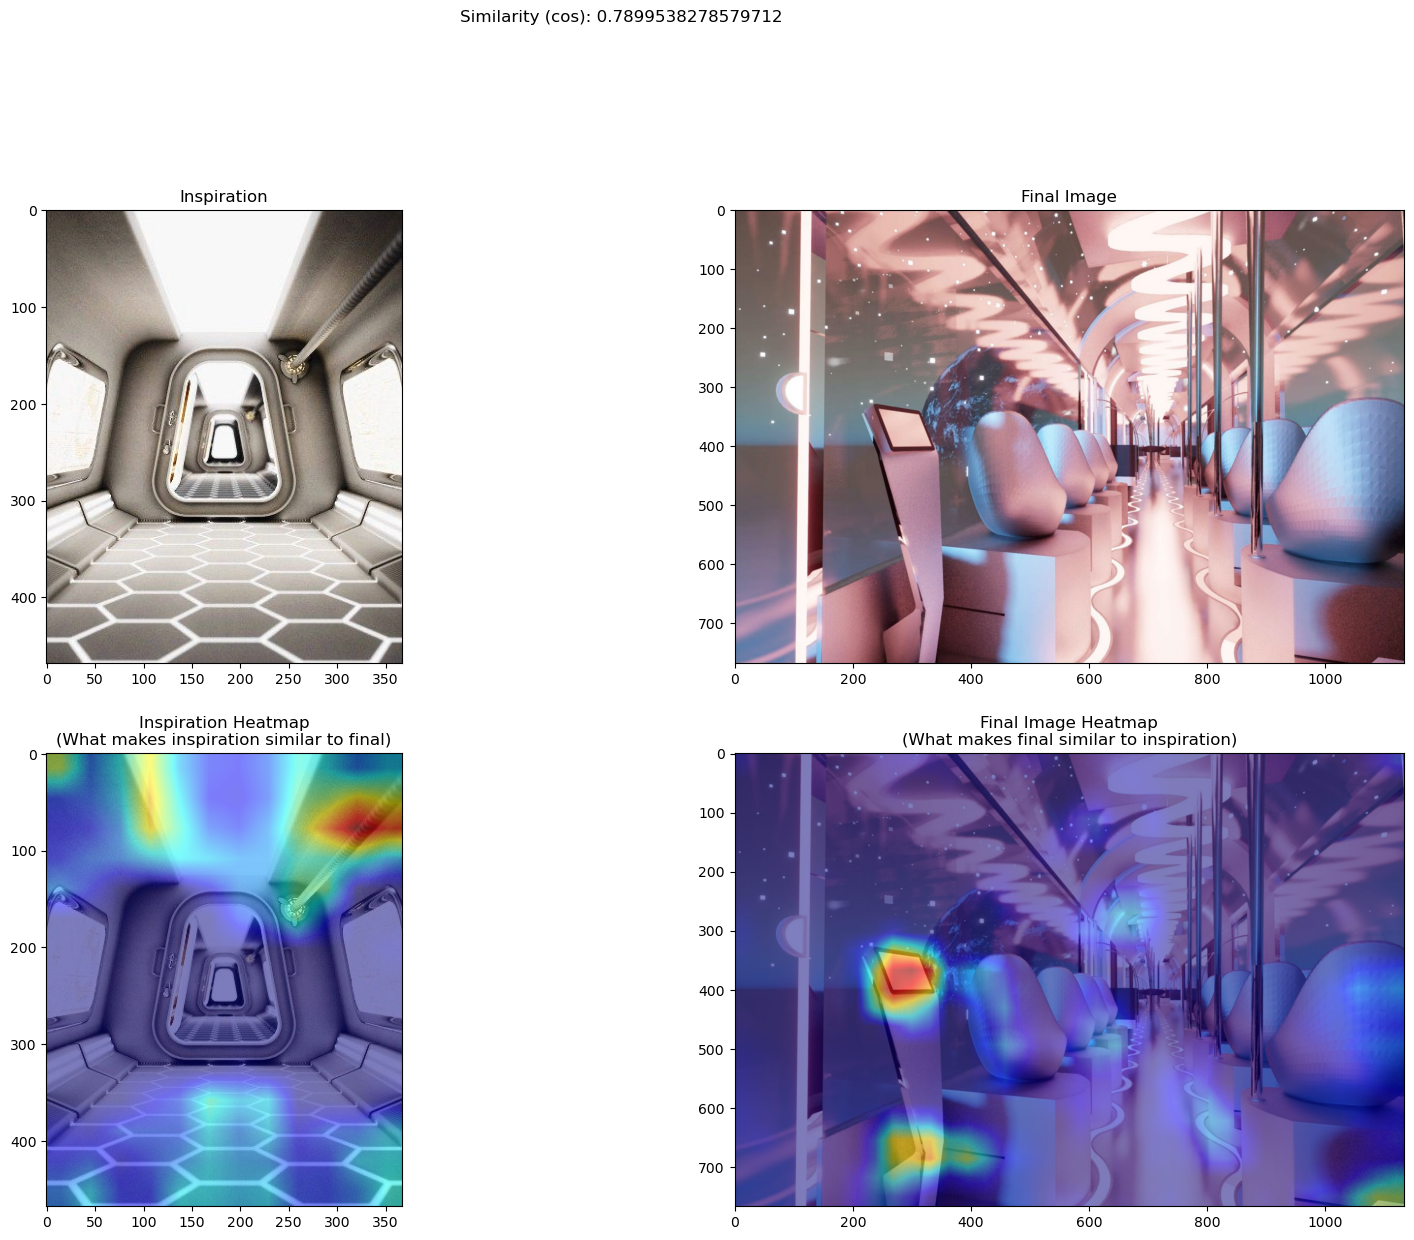

In [5]:
make_comparison_plot_similarity("/home/milte/Desktop/ainspired/data/web/8A_10.JPG","/home/milte/Desktop/ainspired/data/final_submissions/8/1.jpg",model,device)